# Income Analysis

This project aims to use a dataset of incomes of adults from the 1994 Census to create models that can be used to predict whether an individual makes an annual income of greater than 50,000 or not based on characteristics about the individual. Various supervised learning models will be explored to determine how these models perform on this classification task.

The goal of the project is to determine which sociodemographic characteristics about an individual have an influence on their annual income and by how much these characteristics influence the annual income. Doing so could provide insights into social inequalities regarding an individual's income.

## Dataset

The dataset used for this project is titled "Adult" and is from the University of California Irvine's Machine Learning Repository.

Becker, B., & Kohavi, R. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20

In [57]:
import pandas as pd

data = pd.read_csv('./data/raw_data.csv')
print(data.shape)

(48842, 15)


The dataset contains information on adults from the 1994 Census. The dataset includes information on 48,842 individuals with 15 columns.

#### Target Variable

The target variable in this analysis is the "income" variable. This categorical variable indicates whether an individual's income is greater than 50,000 or not.

#### Feature Variables

age (numerical) - Age

workclass (categorical) - Type of work

fnlwgt (numerical) - Final weight of observation

education (categorical) - Highest level of education

education-num (numerical) - Number assigned based on "education" feature

marital-status (categorical) - Marital status

occupation (categorical) - Industry/role

relationship (categorical) - Relationship relative to marital status

race (categorical) - Race

sex (categorical) - Sex

capital-gain (numerical) - Capital gain

capital-loss (numerical) - Capital loss

hours-per-week (numerical) - Average number of hours worked per week

native-country (categorical) - Country of birth

## Data Cleaning, Part 1

The UCI Machine Learning Repository website's page for this dataset mentions that there are missing values in the columns "workclass", "occupation", and "native-country".

In [58]:
missing_values_columns = ['workclass', 'occupation', 'native-country']
for column in missing_values_columns:
    print(f'{column} has missing values: {data[column].isnull().any()}')

workclass has missing values: True
occupation has missing values: True
native-country has missing values: True


These columns do indeed have missing values. For this project, it is best to drop any rows that contain missing values in any of the columns.

In [59]:
print(data.shape)
data = data.dropna()
print(data.shape)

(48842, 15)
(47621, 15)


1,221 rows were dropped since they had missing values.

In [60]:
categorical_vars = data.select_dtypes(exclude='number').columns
for var in categorical_vars:
    print(f'{var}:', data[var].unique())

workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
education: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
marital-status: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
relationship: ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
race: ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex: ['Male' 'Female']
native-country: ['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' '

The "workclass", "occupation", and "native-country" columns still contain values that are the string "?". Rows containing this value in these columns should also be dropped.

In [61]:
data = data[~(data == '?').any(axis=1)]
print(data.shape)

(45222, 15)


An additional 2,399 rows were dropped.

The "education" categorical variable may be redundant because of the "education-num" numerical variable.

In [62]:
print(len(data['education'].unique()))
print(data['education-num'].min(), data['education-num'].max())

16
1 16


There are 16 unique values in the "education" column and the "education-num" column contains integers from 1 to 16. This suggests that the "education" variable can be dropped since it is an ordinal variable and its information is already captured as integers in "education-num".

In [63]:
data = data.drop(columns='education')

The "fnlwgt" column can also be dropped since it is not helpful when building models in this project.

In [64]:
data = data.drop(columns='fnlwgt')

Data munging may also be necessary for some of the categorical variables.

The "income" target variable should be fixed and converted into a binary variable.

In [65]:
income_mapping = { '>50K': 1, '>50K.': 1, '<=50K': 0, '<=50K.': 0 }
data['income'] = data['income'].map(income_mapping)
print(data['income'].unique())

[0 1]


There are a lot of different possible values for the "native-country" variable. It may be more useful to consider whether someone's native country is the United States or not since the census was conducted in the US. Due to these reasons, it is reasonable to transform the "native-country" variable to a binary variable called "us-native" that indicates whether an individual's native country is the US.

In [66]:
data['native-country'] = data['native-country'].apply(lambda x: 1 if x == 'United-States' else 0)
data = data.rename(columns={'native-country': 'us-native'})
print(data['us-native'].unique())

[1 0]


In [67]:
print(data.shape)

(45222, 13)


In summary, as a result of the data cleaning, 3,620 rows and 2 columns were dropped. There is still additional data munging to be done to some of the remaining categorical variables. However, this will be done after the exploratory data analysis in order to make the EDA easier.

## Exploratory Data Analysis

It is helpful to look at the distribution of the numerical features in the dataset.

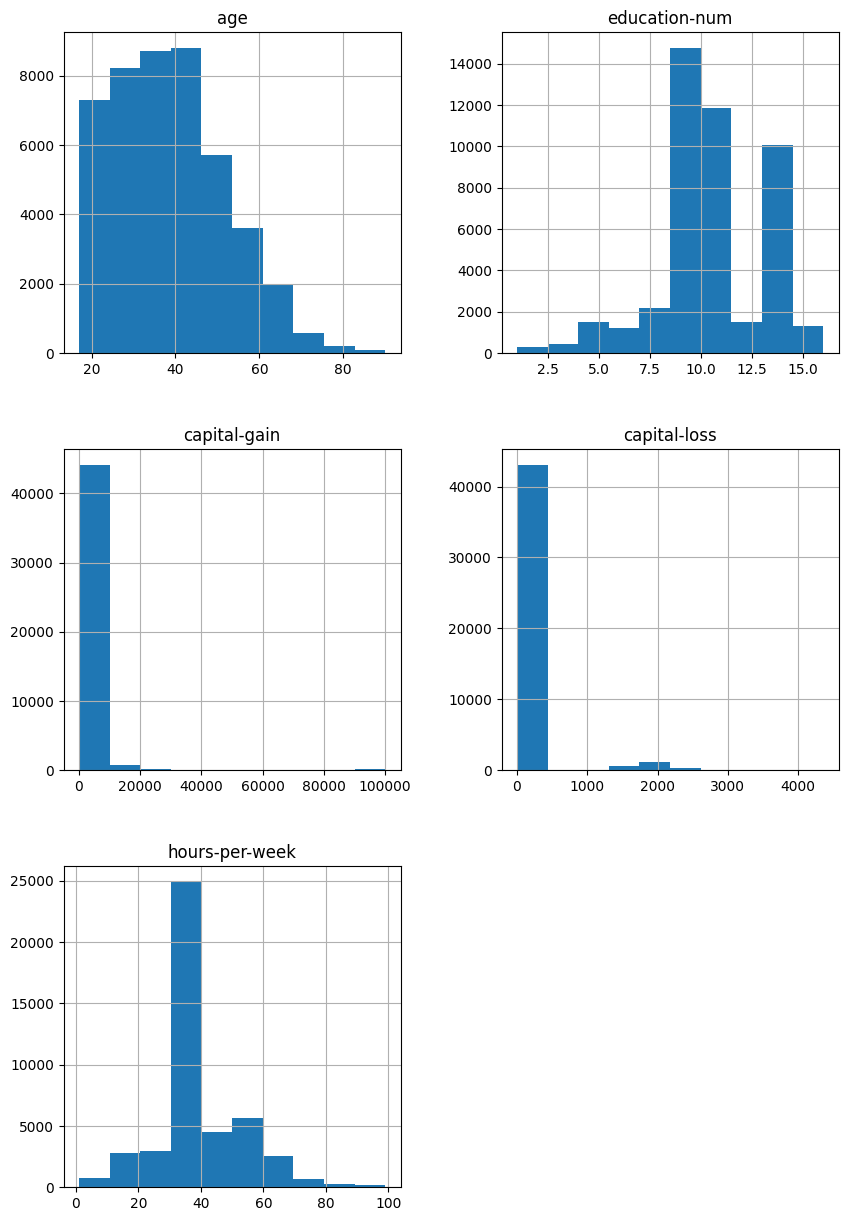

In [68]:
import matplotlib.pyplot as plt

numerical_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
data.hist(column=numerical_features, figsize=(10,15))
plt.show()

The "capital-gain" feature seems to have significant outliers.

In [69]:
max_capital_gain = data['capital-gain'].max()
print(max_capital_gain)
print(data[data['capital-gain'] == max_capital_gain].shape[0])

99999
229


It seems that the values for the "capital-gain" feature have been capped at 99,999 in the dataset. There are 229 rows in the data that have this capped max value. Since this is a capped value and not the true value and since these values are noticeable outliers, it is best to drop the rows that contain this max value.

In [70]:
data = data[~(data['capital-gain'] == max_capital_gain)]
print(data.shape)

(44993, 13)


Analyzing the correlations between the features is helpful in the the model building process.

In [71]:
data[numerical_features].corr()

,age,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,0.033835,0.115972,0.060178,0.100464
education-num,0.033835,1.000000,0.144173,0.083507,0.141353
capital-gain,0.115972,0.144173,1.000000,-0.051076,0.083500
capital-loss,0.060178,0.083507,-0.051076,1.000000,0.055378
hours-per-week,0.100464,0.141353,0.083500,0.055378,1.000000


All of the numerical features have low correlation with each other.

For categorical variables, the Cramér's V measure can be used to find the association between two variables.

In [72]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(x, y):
    crosstab = pd.crosstab(x, y)
    chi2 = chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    k = min(crosstab.shape) - 1
    return np.sqrt(chi2 / n / k)

categorical_features = [c for c in data.columns if c not in numerical_features]
results = pd.DataFrame(index=categorical_features, columns=categorical_features)
for f1 in categorical_features:
    for f2 in categorical_features:
        results.loc[f1, f2] = round(cramers_v(data[f1], data[f2]), 3)

results

,workclass,marital-status,occupation,relationship,race,sex,us-native,income
workclass,1.0,0.077,0.218,0.088,0.06,0.142,0.053,0.158
marital-status,0.077,1.0,0.13,0.487,0.082,0.465,0.113,0.448
occupation,0.218,0.13,1.0,0.177,0.082,0.436,0.114,0.342
relationship,0.088,0.487,0.177,1.0,0.097,0.648,0.119,0.454
race,0.06,0.082,0.082,0.097,1.0,0.116,0.396,0.099
sex,0.142,0.465,0.436,0.648,0.116,1.0,0.009,0.214
us-native,0.053,0.113,0.114,0.119,0.396,0.009,1.0,0.038
income,0.158,0.448,0.342,0.454,0.099,0.214,0.038,1.0


There are several categorical features that have moderate association with each other. Out of these features, the "relationship" feature is of most interest. It has moderate association with both "marital-status" and "sex". This makes sense since this feature contains values based on marital status and if an individual is married, two of the possible values are "Wife" and "Husband" which is based on sex. Therefore, it is reasonable to drop this feature due to this redundancy.

In [73]:
data = data.drop(columns='relationship')
categorical_features.remove('relationship')

It is also worthwhile to look at how the categorical data are distributed.

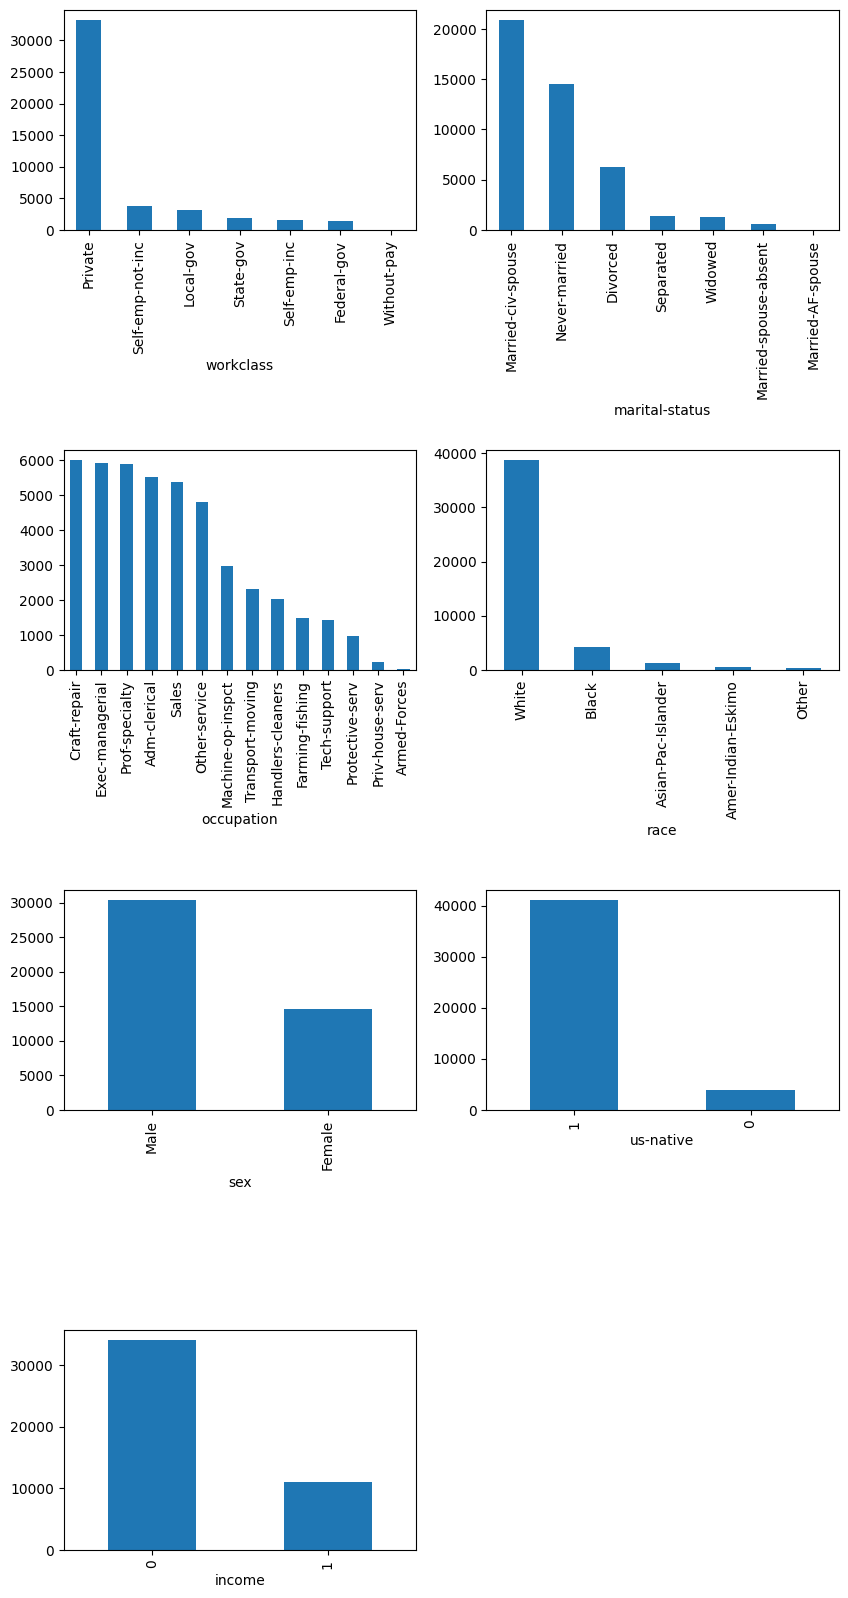

In [77]:
rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols)
fig.delaxes(axs[3][1])
fig.set_figwidth(10)
fig.set_figheight(20)
fig.subplots_adjust(hspace=1.0)

for i in range(rows):
    for j in range(cols):
        if i*2+j == len(categorical_features):
            break
        data[categorical_features[i*2+j]].value_counts().plot(kind='bar', ax=axs[i][j])

To conclude, from the exploratory data analysis, outliers were found for the "capital-gain" feature. These instances were removed from the dataset. The numerical features in the data all had low correlation with each other. Several categorical features had moderate correlation with each other. The "relationship" feature was dropped from the dataset due to the correlations with other features and redundancy. There were no other major issues based on the plots for the distributions of the features.